<a href="https://colab.research.google.com/github/zwe-htet-paing/notebooks/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 376 kB 55.9 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=fbb75d669f1c76668f6b4f28b93081810384be7864c093936fe4ad69e3b215cf
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c65961b4e968cab39cbf3911da252037d6a2708fcb155cb7beacf5e6f8fd36d1
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

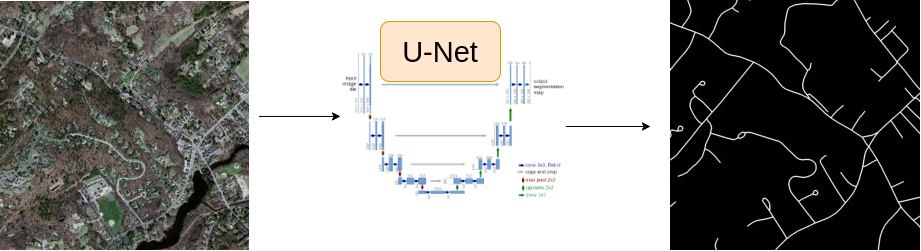

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.002
IMG_SIZE = 512
BATCH_SIZE = 8

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

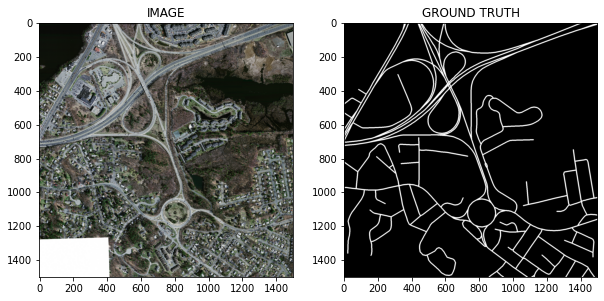

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE), 
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255 # (h, w)
    mask = np.expand_dims(mask, axis=-1) # (h, w, c)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image'] # (h, w, c)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) # (c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print("Size of trainset: ", len(trainset))
print("Size of validset: ", len(validset))

Size of trainset:  159
Size of validset:  40


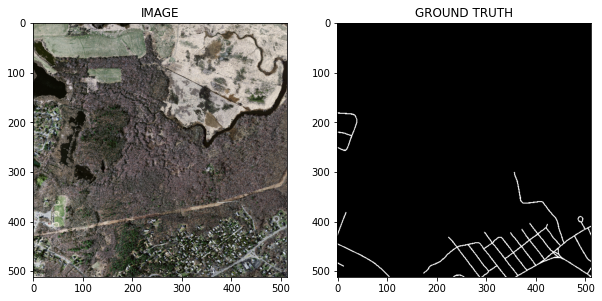

In [ ]:
idx = 21

image, mask = validset[idx]
# mask = torch.round(mask)

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in validloader: {len(validloader)}")

Total number of batches in trainloader: 20
Total number of batches in validloader: 5


In [ ]:
for images, masks in trainloader:
  print(f"One batch images shape: {images.shape}")
  print(f"One batch masks shape: {masks.shape}")
  break;

One batch images shape: torch.Size([8, 3, 512, 512])
One batch masks shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(model, dataloader, optimizer):

  model.train() # Turn on Droput, batchnorm, etc...
  total_loss = 0.0

  for data in tqdm(dataloader):

    images, masks = data
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):

  model.eval() # Turn OFF Droupout, batchnorm, etc..

  total_losss = 0.0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, masks = data
      images, masks = images.to(DEVICE), masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss = loss.item()

    return total_loss / len(dataloader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_losss = valid_loss

  print(f"Epochs: {i+1} | train_loss: {train_loss} | valid_loss: {valid_loss}")

100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 1 | train_loss: 0.9973518818616867 | valid_loss: 0.19962122440338134


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED-MODEL
Epochs: 2 | train_loss: 0.9973029255867004 | valid_loss: 0.19961974620819092


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 3 | train_loss: 0.9971900582313538 | valid_loss: 0.19961529970169067


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 4 | train_loss: 0.9971784710884094 | valid_loss: 0.1996544599533081


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 5 | train_loss: 0.9970513224601746 | valid_loss: 0.19955729246139525


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 6 | train_loss: 0.997072622179985 | valid_loss: 0.19941540956497192


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 7 | train_loss: 0.9970243841409683 | valid_loss: 0.19952309131622314


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epochs: 8 | train_loss: 0.9970470160245896 | valid_loss: 0.19960557222366332


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epochs: 9 | train_loss: 0.9970180720090867 | valid_loss: 0.19946848154067992


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epochs: 10 | train_loss: 0.9969846040010453 | valid_loss: 0.19946072101593018


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


SAVED-MODEL
Epochs: 11 | train_loss: 0.9969836860895157 | valid_loss: 0.19948079586029052


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 12 | train_loss: 0.9969196051359177 | valid_loss: 0.1997319221496582


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 13 | train_loss: 0.9969837725162506 | valid_loss: 0.19940749406814576


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED-MODEL
Epochs: 14 | train_loss: 0.9969405651092529 | valid_loss: 0.19950140714645387


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 15 | train_loss: 0.9968982934951782 | valid_loss: 0.1994403600692749


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 16 | train_loss: 0.996881639957428 | valid_loss: 0.19943500757217408


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 17 | train_loss: 0.9968110203742981 | valid_loss: 0.19945662021636962


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 18 | train_loss: 0.9968486726284027 | valid_loss: 0.19957892894744872


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 19 | train_loss: 0.9967837423086167 | valid_loss: 0.19968394041061402


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED-MODEL
Epochs: 20 | train_loss: 0.996826583147049 | valid_loss: 0.1995236396789551


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


SAVED-MODEL
Epochs: 21 | train_loss: 0.9967961400747299 | valid_loss: 0.1995063066482544


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epochs: 22 | train_loss: 0.996780839562416 | valid_loss: 0.19959450960159303


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 23 | train_loss: 0.9968066275119781 | valid_loss: 0.19943630695343018


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epochs: 24 | train_loss: 0.9967115432024002 | valid_loss: 0.19948246479034423


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

SAVED-MODEL
Epochs: 25 | train_loss: 0.9967438966035843 | valid_loss: 0.19951597452163697


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.unsqueeze(0).to(DEVICE)) # (c, h, w) --> (bs, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
# pred_mask = (pred_mask > 0.5)*1.0

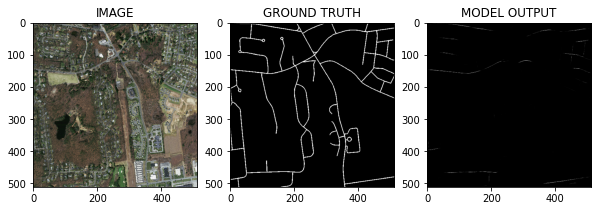

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))